# INFO 3350/6350

## Lecture 09: Topic models

## From words to topics

* If we want to know what our documents are about -- that is, if we want to measure their content -- we can count the words in them
* Words are good, but imperfect, features, as noted in previous lectures
    * Words split one subject or topic across multiple features
        * Example: The subject "pets" can be materialized as "cat", "kitten", "dog", "parakeet", etc.
    * Words also *fail* to split subjects that are distinct
        * Example: "fall" is a season, a physical action, and/or a state of defeat or disgrace
        * This is called *polysemy* (literally, "many signs")
    * Lemmatization helps a little with these issues, but not as much as we'd like
* We would (sometimes) like a way to replace words with subjects or topics
    * If there are fewer distinct topics than there are distinct words, we would thus trade specificity for generality
* Words -> topics would help us in two ways ...
    * Identifying topics would give us a better sense of what's in our documents
        * Related to search and information retrieval
            * How do you search if you don't know what's in your documents?
            * Or what if the documents use nonstandard language or talk around an issue?
        * It's easy to forget how often we have this problem in text analysis
        * Corpora are usually *big*; if you could read them, you wouldn't be using text mining to study them
        * *Exploratory* analysis is often warranted
    * Transforming words into topics would help with overfitting in our models by reducing the dimensionality of our feature space
        * This is a big deal, too
        * We can reduce dimensions, but the reduced version often becomes hard to interpret
        * Reduced dimensions that correspond to distinct subject matter help with explainability
        
## Topic models

* A topic model is any model of a corpus that has a mathematical representation of:
    * **Documents:** Containers of text that are composed from a limited number of topics
    * **Topics:** Sets of words or other tokens (or probability distributions across a vocabulary) that together are used to express a (coherent?) subject or idea
    * **Words:** Specific tokens from which topics and documents are built
* Topic models are **unsupervised**
    * This is not a classification task. We don't know in advance what are the "correct" topics, nor what words belong to which topic, nor how much of each topic is in each document.
* Topic models generally operate on word counts (so-called "bags of words"), hence do not require full, sequential texts
    * This is useful if, for some reason, you can get word counts but not full texts (copyright laws, typically)
* The earliest model that might be described as a topic model was called **Latent Semantic Analysis (LSA)**
    * In short: Truncated SVD to reduce dimensionality
        * Each dimension is a topic
    * Then examine the feature weights within each dimension
        * Feature weights tell you how much of each word is captured by each dimension
    * Each document contains some amount of each dimension
        * These are your document topic proportions
    * Can perform document similarity measurement on topic composition via the usual distance metrics (often, cosine distance)
* LSA tends to produce "diffuse" topics, since it has no inherent mechanism to encourage sparsity
    * That is, topics contain non-trivial weights for a lot of different words
    * And documents contain nontrivial amounts of many topics
    * Good similarity performance, poor interpretability
* Now, we generally use **Latent Dirichlet Allocation (LDA)** to produce **probabilistic topic models**
    * The Dirichlet distribution allows us to parameterize "*concentration*", that is, the degree to which the topical distribution in each document is expected to be sparse
    * Topical sparsity has big advantages when it comes to interpretability
    * See assigned reading for the mathematical details
        * The math isn't super hard, but it's also not our immediate concern

## The standard model of LDA

Or, where do baby documents come from?

We need a data-generating process that we can model. So, imagine we're a decent programmer and terrible fiction writer. How would we write a book?

[Hand sketch ...]

* Note that **no one thinks writers work this way** (except maybe for language poets)
* A model doesn't have to be correct to be useful

## LDA in `sklearn`

* There are lots of topic modeling packages, each of which implements some shared features and many of which introduce advanced variations (topics over time, authorless models, semi-supervised topics, etc.)
* MALLET is one of the oldest and best topic modeling packages
    * Maintained by David Mimno in Cornell IS!
    * But it's in Java
        * Java is fine, but a pain to use alongide Python
    * Check out Prof. Mimno's [online topic modeling tool](https://mimno.infosci.cornell.edu/jsLDA/)
* [tomotopy](https://bab2min.github.io/tomotopy/v0.13.0/en/) is a pure-python implementation of much of MALLET
* We'll use scikit-learn, since it integrates so seamlessly with our other workflows
    * Adequately(?) fast, decent performance, lacks bells and whistles

## Preprocessing matters

* LDA topic models can be sensitive to preprocessing decisions
* Chunking and stopword removal are important
* Remember, the algorithm doesn't have a human "concept" of a topic
    * Is a topic a specific idea? A way of speaking? A high-level theme? A genre of literature?
        * The algorithm doesn't know!
* The Dirichlet distribution "wants" to produce sparse topics
    * If you use long documents that are "about" a lot of different things, your topics will be diffuse and "smear-y"
    * If your documents are short and focused on one or two ideas, your topics will be cleaner and more interpretable
        * Congressional policy speeches or press releases are good examples of whole documents that focus on one or two topics
    * In many cases, chunking by paragraph, page, or several-hundred-word passage is appropriate
    * But aggressive chunking can produce very large matrices, even in modest corpora
        * May need streaming approaches with online updates to manage memory consumption
* LDA doesn't need word order, so is well suited to "non-consumptive" or "non-expressive" use
    * Sources: [HTRC extracted features](https://analytics.hathitrust.org/datasets), [JSTOR DfR](http://www.jstor.org/dfr)
    * Hence usable with in-copyright texts that are only available as bags of words
    * Preprocessing can be trickier with these, because you do not control tokenization or chunking
    
## The US State of the Union (SOTU) address, 1791-2018

* An annual address by the president of the US to congress
* Describes political issues, priorities, and programs
* Corpus contains 227 speeches, total of about 1.75M words
* A now-classic demo for topic models

In [1]:
from   glob import glob
import os

# Where's the data?
corpus_dir = os.path.join('..', 'data', 'sotu')
files = glob(os.path.join(corpus_dir, '*.txt'))

# Read files and chunk by paragraphs
texts = []
years = []
for file in files:
    metadata = os.path.basename(file).split('.')[0]
    year = int(metadata.split('_')[1]) # file names are President_Year.txt
    with open(file, 'r') as f:
        text = f.read()
        for paragraph in text.split('\n\n'): # Paragraph break is two newlines
            texts.append(paragraph)
            years.append(year)
print("Number of SOTU texts:", len(files))
print("Number of paragraphs:", len(texts))
print("Years:", min(years), 'through', max(years))

Number of SOTU texts: 227
Number of paragraphs: 21143
Years: 1791 through 2018


In [2]:
# Vectorize
from   sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english', # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25    # Ditto
)

X = vectorizer.fit_transform(texts)
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized paragraph length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (21143, 4922)
Total vectorized words in the corpus: 705011
Average vectorized paragraph length: 33 tokens


In [3]:
%%time
from   sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 1.02 s, sys: 315 ms, total: 1.34 s
Wall time: 16.2 s


LatentDirichletAllocation(evaluate_every=0, n_components=20, n_jobs=-1,
                          verbose=1)

In [4]:
# exmaine the fitted model directly
print(lda.components_.shape)
lda.components_[:10]

(20, 4922)


array([[5.00000004e-02, 7.21383054e+01, 8.37391355e+01, ...,
        5.00000007e-02, 5.00000000e-02, 5.00000008e-02],
       [5.00000000e-02, 5.00000005e-02, 5.65161690e-01, ...,
        5.00000249e-02, 1.66197319e+01, 5.00000005e-02],
       [5.00000000e-02, 5.00000005e-02, 5.00000003e-02, ...,
        2.08794633e+00, 5.00000004e-02, 5.00000011e-02],
       ...,
       [5.00000000e-02, 5.00000003e-02, 5.00366626e-02, ...,
        5.00000001e-02, 5.00000006e-02, 5.00000021e-02],
       [5.00000001e-02, 5.00000007e-02, 5.00000005e-02, ...,
        5.00000020e-02, 5.00000007e-02, 5.00000000e-02],
       [5.00000004e-02, 5.00000013e-02, 9.62053415e-01, ...,
        4.60706026e+01, 5.00000003e-02, 5.32932335e+00]])

So, for each of 20 topics, we have a distribution over the vocabulary. Ehh ... maybe we can do better for interpretability?

In [5]:
# Print top words per topic

def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [6]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: tax year health budget care jobs new years million americans
Topic  1: war army navy military naval force officers men secretary coast
Topic  2: public lands land government shall great resources policy country private
Topic  3: states united government treaty mexico great citizens convention britain minister
Topic  4: department general service post transportation mail lines office postal postmaster
Topic  5: 000 year increase number cent total years value canal increased
Topic  6: world war nations economic peace defense forces military international free
Topic  7: congress legislation subject attention message action commission consideration shall session
Topic  8: government banks gold bank currency money country silver national public
Topic  9: federal government program education new local programs administration national help
Topic 10: service public congress department government executive present time officers general
Topic 11: labor law business work men man governm

In [7]:
# Install pyLDAvis
#  Uncomment to run
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge pyldavis

In [8]:
import pyLDAvis
import pyLDAvis.lda_model
import warnings

pyLDAvis.enable_notebook()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_vis = pyLDAvis.lda_model.prepare(lda, X, vectorizer, mds='pcoa', sort_topics=False)
pyLDAvis.display(lda_vis)

**Note** that `pyLDAvis` sorts topics in order of descending overall frequency in the corpus unless you pass `sort_topics=False`. This behavior can make it hard to use for exploratory work, so keep `sort_topics=False` in place unless you know what you're doing. And note that `pyLDAvis` has renumbered the topic identifiers to start from `1`, so be careful with alignment issues.

In [9]:
# Create a doc-topic matrix
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (21143, 20)


In [10]:
# Examine topic distribution in a random paragraph
import random
doc_idx = random.randrange(len(doc_topic_matrix))
print(f"Topic distributions in paragraph {doc_idx} ({years[doc_idx]})")
print("The text:\n", texts[doc_idx], "\n")
display(doc_topic_matrix[doc_idx])
print()
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic distributions in paragraph 1812 (1901)
The text:
 The Congress assembles this year under the shadow of a great calamity.
On the sixth of September, President McKinley was shot by an anarchist
while attending the Pan-American Exposition at Buffalo, and died in
that city on the fourteenth of that month. 



array([0.003125  , 0.003125  , 0.003125  , 0.003125  , 0.003125  ,
       0.34202603, 0.003125  , 0.10929017, 0.07690925, 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.17382758, 0.003125  ,
       0.003125  , 0.11903217, 0.003125  , 0.003125  , 0.1351648 ])


Topic  0: tax year health budget care jobs new years million americans
Topic  1: war army navy military naval force officers men secretary coast
Topic  2: public lands land government shall great resources policy country private
Topic  3: states united government treaty mexico great citizens convention britain minister
Topic  4: department general service post transportation mail lines office postal postmaster
Topic  5: 000 year increase number cent total years value canal increased
Topic  6: world war nations economic peace defense forces military international free
Topic  7: congress legislation subject attention message action commission consideration shall session
Topic  8: government banks gold bank currency money country silver national public
Topic  9: federal government program education new local programs administration national help
Topic 10: service public congress department government executive present time officers general
Topic 11: labor law business work men man govern

/Users/mw966/miniforge3/envs/3350/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mw966/miniforge3/envs/3350/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mw966/miniforge3/envs/3350/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


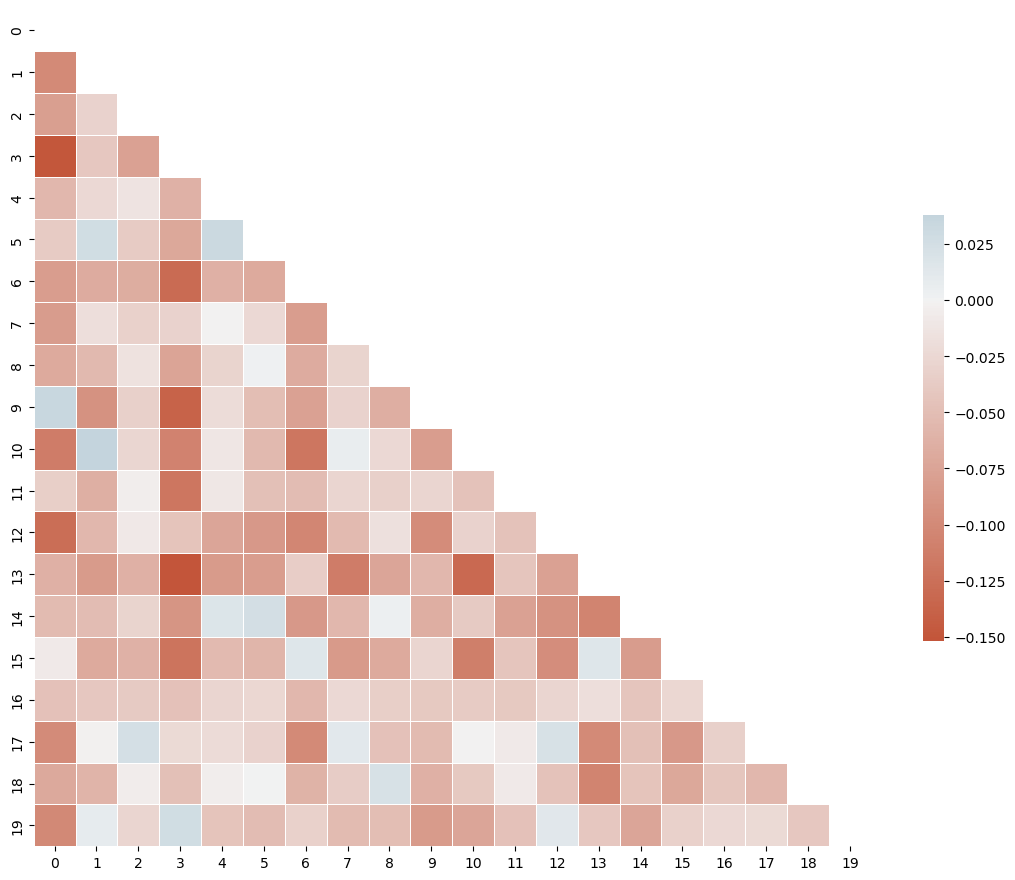

In [11]:
# Correlation plot
#  Adapted from Seaborn docs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from   sklearn.preprocessing import StandardScaler

#sns.set_context('talk')
corr = np.corrcoef(doc_topic_matrix.T)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.tight_layout()
plt.show()

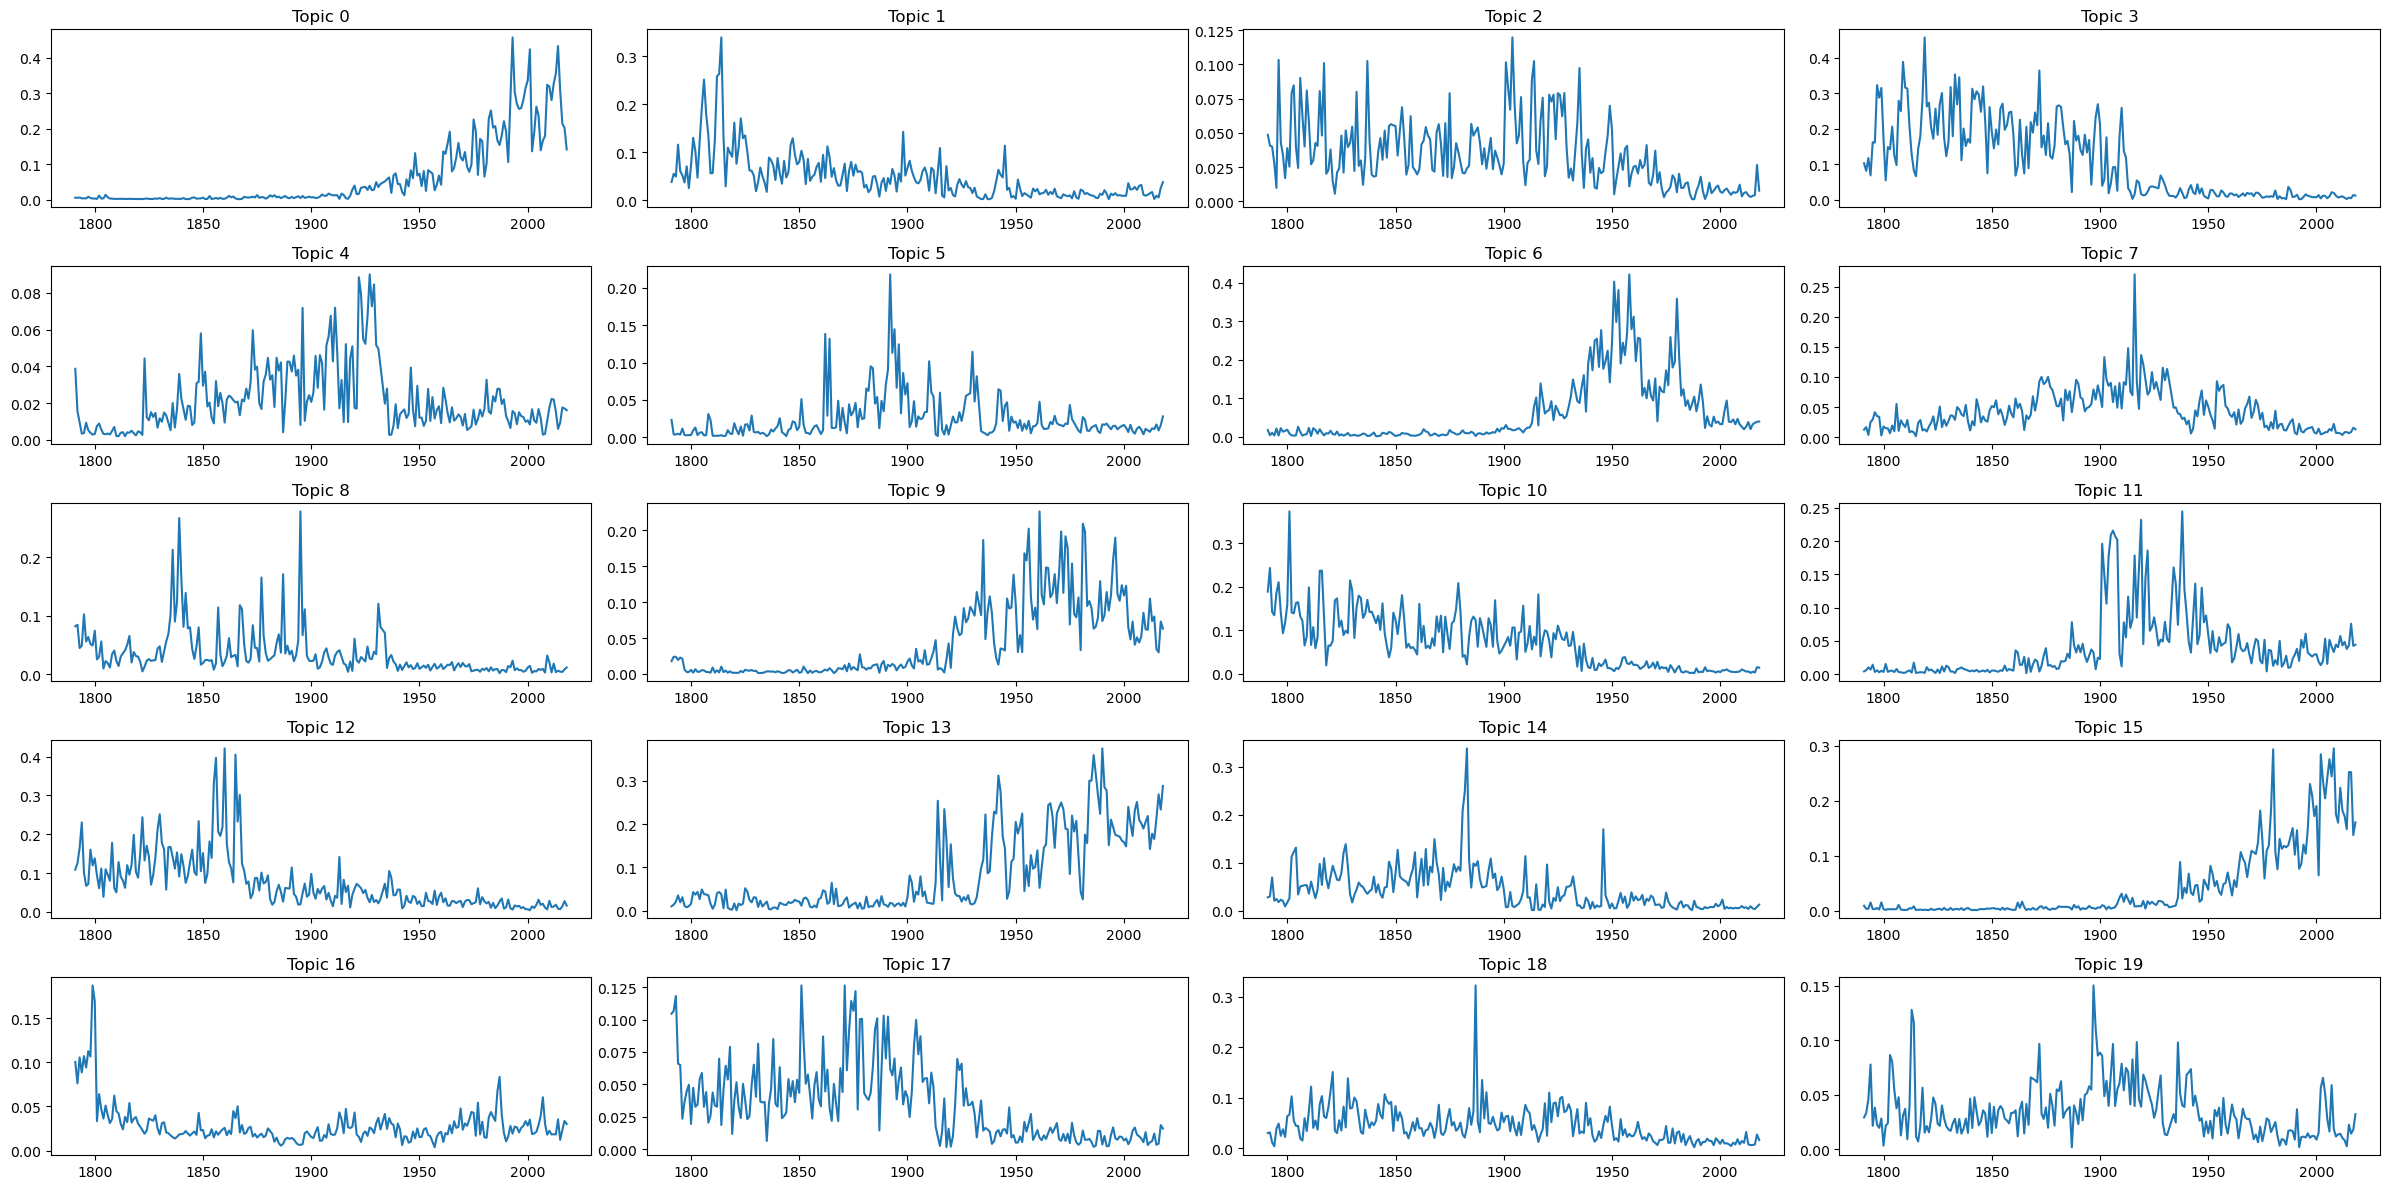

In [12]:
# Time series
n_cols = 4
n_topics = doc_topic_matrix.shape[1]
n_rows = n_topics/n_cols
if n_rows%1!=0:
    n_rows += 1
n_rows = int(n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(24,12))
axs = axs.ravel()

valid_years = sorted(np.unique(years))
for topic in range(n_topics):
    topic_data = doc_topic_matrix[:,topic]
    topic_means = []
    for year in valid_years:
        mask = np.equal(years, year)
        topic_mean = np.mean(topic_data[mask])
        topic_means.append(topic_mean)
    axs[topic].plot(valid_years, topic_means)
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

In [13]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: tax year health budget care jobs new years million americans
Topic  1: war army navy military naval force officers men secretary coast
Topic  2: public lands land government shall great resources policy country private
Topic  3: states united government treaty mexico great citizens convention britain minister
Topic  4: department general service post transportation mail lines office postal postmaster
Topic  5: 000 year increase number cent total years value canal increased
Topic  6: world war nations economic peace defense forces military international free
Topic  7: congress legislation subject attention message action commission consideration shall session
Topic  8: government banks gold bank currency money country silver national public
Topic  9: federal government program education new local programs administration national help
Topic 10: service public congress department government executive present time officers general
Topic 11: labor law business work men man governm

Note the strong temporal trends in topic frequency. Maybe we can predict speech date from topical content?

Mean cross-validated R^2 (topics): 0.624


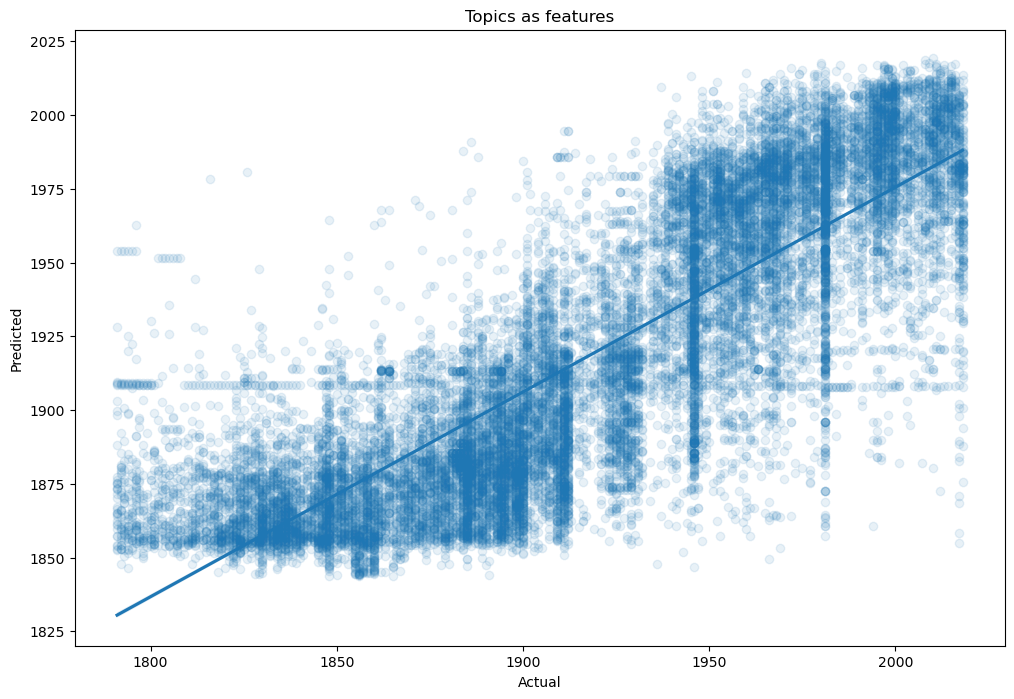

In [14]:
# Predict speech date from topic content
from   sklearn.linear_model import LinearRegression
from   sklearn.model_selection import cross_val_score

# Fit and predict using topics
X_topics = StandardScaler().fit_transform(doc_topic_matrix)
predictor = LinearRegression().fit(X_topics, years)
y_pred = predictor.predict(X_topics)

# Score
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_topics, years, scoring='r2', cv=10)),3))

# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x=years, y=y_pred, scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Topics as features")
plt.show()

In [15]:
# Ditto, using 20 best word features
from   sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

# Select best word features
method = f_regression
selector = SelectKBest(method, k=20)
X_words = selector.fit_transform(X, years)

# Score
print("Mean cross-validated R^2 (words):", round(np.mean(cross_val_score(LinearRegression(), X_words, years, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (words): 0.199


Predicting by topics performs **much** better than predicting by the same number of "best" word features!

Also: `mutual_info_regression` is much more robust than is `f_regression` as a measure of association (F measures linear relationships between inputs and outputs; MI in nonparametric and can capture any relationship), but the former is also much slower to calculate (like, c. 1000x) than is the latter.

In [16]:
# Ditto, using SVD with 20 components
from   sklearn.decomposition import TruncatedSVD

# Find top 20 SVD components
reducer = TruncatedSVD(n_components=20)
X_svd = reducer.fit_transform(X)

# Score
print("Mean cross-validated R^2 (SVD):", round(np.mean(cross_val_score(LinearRegression(), X_svd, years, scoring='r2', cv=10)),3))

Mean cross-validated R^2 (SVD): 0.336
